In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import sys
sys.path.insert(0, '/home/voehring/gpu-py38/lib/python3.8/site-packages')
sys.path.append('/home/voehring/voehring/opt/scCCA')
from IPython.display import Image
from IPython.core.display import HTML 

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scCCA as scc
import seaborn as sns

# Analysing single Kang et. al.

In this notebook, we analyse the Kang et. al. dataset in which the authors stimulated PBMCs with Interferon-$\beta$. We load the dataset using `scanpy`.

In [25]:
adata = sc.read_h5ad('/home/voehring/voehring/projects/2022-11-23_constantin/kang.h5ad')

The canonical approach to analyse single cell datasets is to first select highly variable genes followed by a logCPM transformaton. The transformed data are then subjected to PCA dimensionality reduction prior to subsequent downstream analyses.

In [26]:
adata.layers["counts"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True,
    layer="counts"
)

In [27]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [28]:
sc.tl.pca(adata, n_comps=15)

We now generate a UMAP from PCA cell embeddings to obtain an overview of the dataset. The `scc.tl.umap` function first creates a nearest neighborhood graph and subsequently calculates UMAP coordinates.

In [29]:
scc.tl.umap(adata, 'X_pca')

Plotting the UMAPs reveals that although the PCA embeddings preserved the cellular identity within both conditions, it fails to align those properly within within UMAP space. This results in a separation of control and stimulated cells along the second UMAP axis (`X_pca_umap2`).

/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


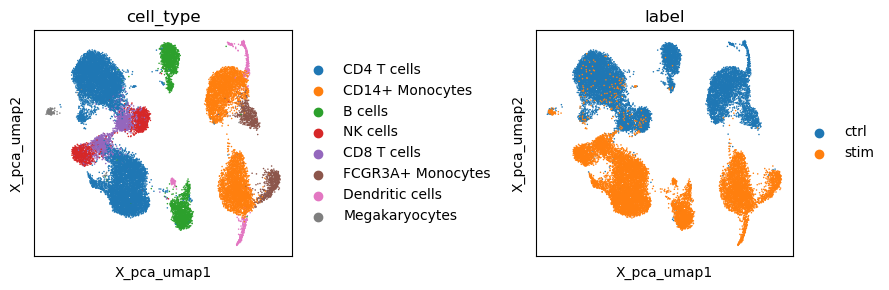

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_pca_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_pca_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

To understand why this ist the case we proceed by investigating the PCA factors. In particular, we plot the factor weights of the first few principal components using `scc.pl.factor_embedding` function on top of the UMAP coordinates. Visual inspection of the resulting plot indicates that the first factor (`Factor 0`) is likely to represent an axis of variation that delineates CD14+/FCGR3A+ Monocytes and dendritic cells from all other cell types within the dataset. The second principal component (`Factor 1`) however seems to delineate the condition, i.e. whether the cell origins from the control or stimulated experiment.

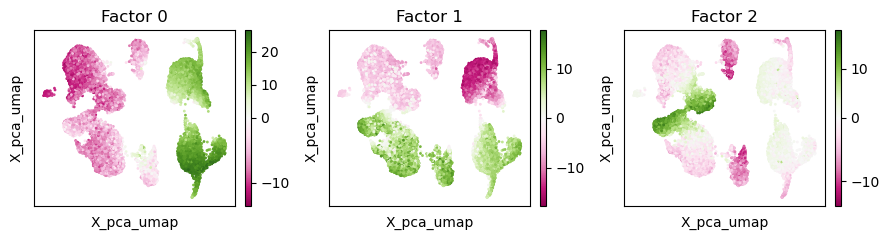

In [123]:
scc.pl.factor_embedding(adata, 'pca', 'X_pca_umap', factor=[0, 1, 2], width=3, height=2.5)
plt.tight_layout()

## Analysing interferon beta stimalted single cell data using scPCA

While the separation of cells across conditions is expected, it poses potential problems for further downstream analyses. Clustering by cell type, for example, is difficult due to the presence of `Factor 1` which separates similar cell types by condition. For this reason, it is desirebable to account for the experimental condition while performing the dimensionality reduction. In `scPCA`, we may account for the experimental condition by informing the model about the condition of each cell using design matrices. To understand how, we consider the usage of different design matrices and explore the consequences on the fitted latent representation.


### Recovering PCA, i.e. providing no information about the condition

To recover results that are similar to the PCA baseline we may consider providing two rank 1 matrices $D_1, B_1$ full of ones (depicted as black squares) as loading and intercept design matrix.

In [48]:
Image(url="img/base_kang.png", width=150, height=100)

To instantiate such a model, we call the `scc.scPCA` constructor and provide it with the `anndata` object containing our data, the number of factors to extract and the R-style formulas for the loading (`design_formula`) and intercept (`batch_formula`) matrices. The `scPCA` constructor returns a model which we may fit by excecuting the `.fit()` method which by default trains the model aggressively with a learning rate `0.01` for 5000 training epochs. Further training steps at a lower learning are often beneficial and may be added by calling the `.fit` method for a second time.

In [57]:
m0 = scc.scPCA(adata, 15, layers_key='counts', design_formula='1', batch_formula='1')

In [58]:
m0.fit()

  0%|                                                                                                             | 0/5000 [00:00<?, ?it/s]/g/huber/users/voehring/opt/scCCA/scCCA/model.py:206: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  α_rna = deterministic("α_rna", (1 / α_rna_inv).T)
Epoch: 4990 | lr: 1.00E-02 | ELBO: 7821718 | Δ_10: -18480.00 | Best: 7564252: 100%|████████████████████| 5000/5000 [03:20<00:00, 24.96it/s]


In [59]:
m0.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7808656 | Δ_10: -89072.50 | Best: 7498146: 100%|████████████████████| 2000/2000 [01:18<00:00, 25.61it/s]


To obtain the results we invoke the `.mean_to_anndata` function which computes the posterior mean of fitted parameters and stores them to the anndata object. Specifying `model_key` specifies a prefix such that the added keys in `anndata` object may the parameters of multiple models.

In [60]:
m0.mean_to_anndata(model_key='m0')

Predicting z for obs 24576-24672.: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.85it/s]


In [61]:
adata

AnnData object with n_obs × n_vars = 24673 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'multiplets', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'ident'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay', 'hvg', 'log1p', 'pca', 'X_pca', 'umap', 'label_colors', 'cell_type_colors', 'm0'
    obsm: 'X_pca', 'X_pca_umap', 'X_m0'
    varm: 'PCs', 'm0_W_rna', 'm0_V_rna', 'm0_α_rna', 'm0_σ_rna'
    layers: 'logcounts', 'counts', 'm0_μ_rna', 'm0_offset_rna'
    obsp: 'X_pca_distances', 'X_pca_connectivities'

We next compute a UMAP visualization on the embeddings of `m0`.

In [62]:
scc.tl.umap(adata, 'X_m0')

/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


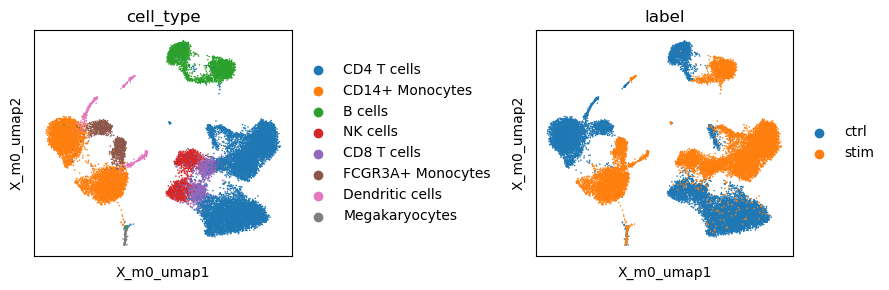

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m0_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m0_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

We find that the UMAP plot from `scPCA` cell embedding looks similar in terms of separation of cells by condition. We again look at the fitted factors$^1$ to obtain a better understanding about the captured "principal axis" of variation$^2$. Similar to PCA, we find a factor that seemingly delineates monocytes and dendritic cells from all other cells (`Factor 1`). The model also captured factors that explain differences between the control and stimulated condition (`Factor 0`, `Factor 4`).

----
$1$: We plot all facors because unlike in PCA returned factors are not sorted by the amount of variance explained.<br>
$2$: Strictly speaking `scPCA` does not extract the principal axes of the data as it emlpoys a non-isotropic noise model.

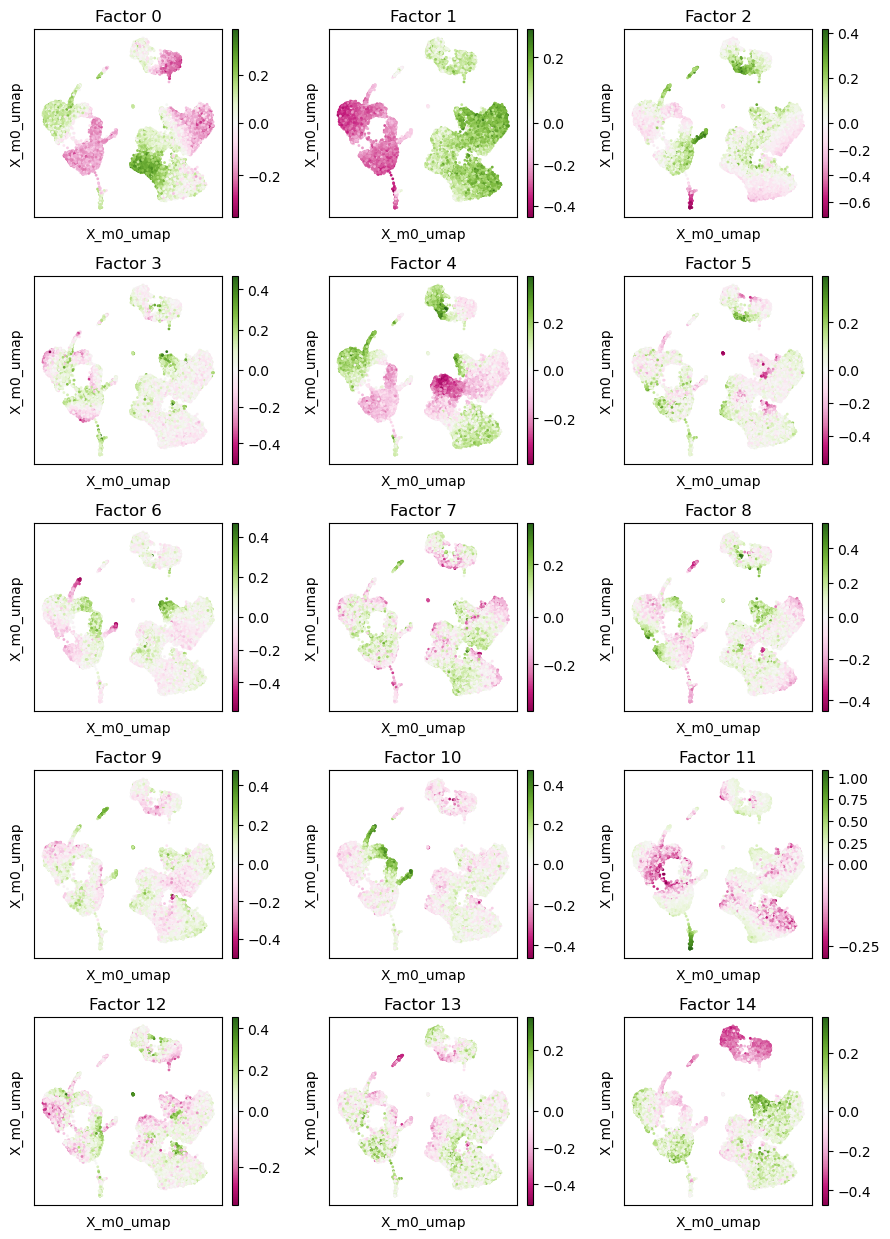

In [122]:
scc.pl.factor_embedding(adata, 'm0', 'X_m0_umap', width=3, height=2.5, ncols=3)
plt.tight_layout()

### Accounting for mean offsets using intercept design matrix

As a first step we try to account for potential shifts in mean gene expression across conditions. Evidence for such shifts may be obtained by exploring how the number of total counts per cell differ between experimental condition.

In [101]:
adata.obs['label'] = pd.Categorical(adata.obs['label'], categories=['ctrl', 'stim'], ordered=True)
adata.obs['total_counts'] = np.asarray(adata.layers['counts'].sum(1)).reshape(-1)

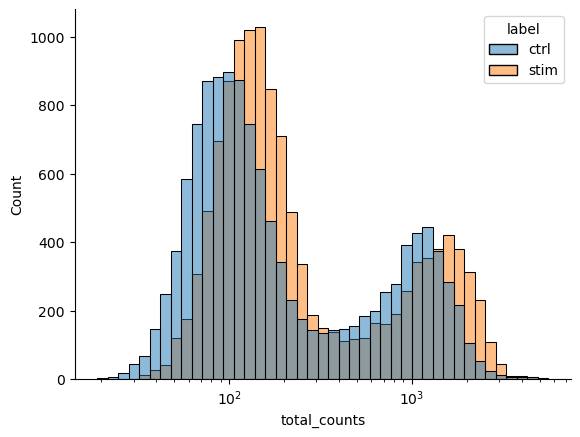

In [102]:
sns.histplot(x='total_counts', hue='label', data=adata.obs, log_scale=True)
sns.despine()

We find that cells from the stimulated condition tend to have a larger number of counts. To instruct the model to fit different means for both conditions, we consider the intercep design matrix $B_2$ which we may create by using the R-style formula `label-1`.

In [100]:
Image(url="img/mean_kang.png", width=150, height=100)

In [103]:
m1 = scc.scPCA(adata, 15, layers_key='counts', design_formula='1', batch_formula='label-1')

In [104]:
m1.fit()

Epoch: 4990 | lr: 1.00E-02 | ELBO: 7875530 | Δ_10: -52621.50 | Best: 7604128: 100%|████████████████████| 5000/5000 [03:12<00:00, 25.98it/s]


In [106]:
m1.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7746470 | Δ_10: 60858.00 | Best: 7559766: 100%|█████████████████████| 2000/2000 [01:16<00:00, 26.06it/s]


In [107]:
m1.mean_to_anndata(model_key='m1')

Predicting z for obs 24576-24672.: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.95it/s]


As before we proceed by computing an UMAP to observe the information captured by the factors. 

In [108]:
scc.tl.umap(adata, 'X_m1')

/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


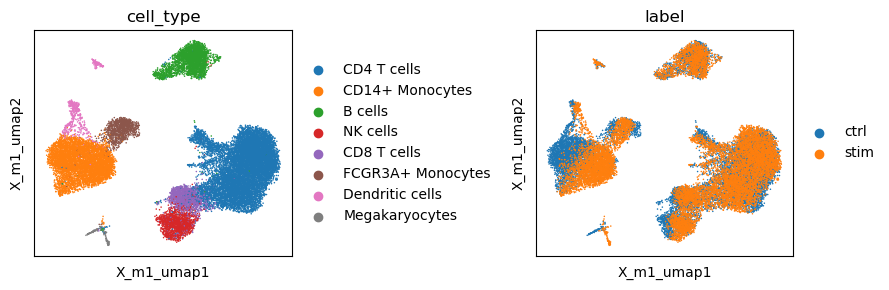

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m1_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m1_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

Strikingly, we observe that accounting for mean expression across coditions improves mixing across conditions whilst preserving the identity of cells. Inspection of factors reveals the absence of a factor that clearly delineates the experimental condition.

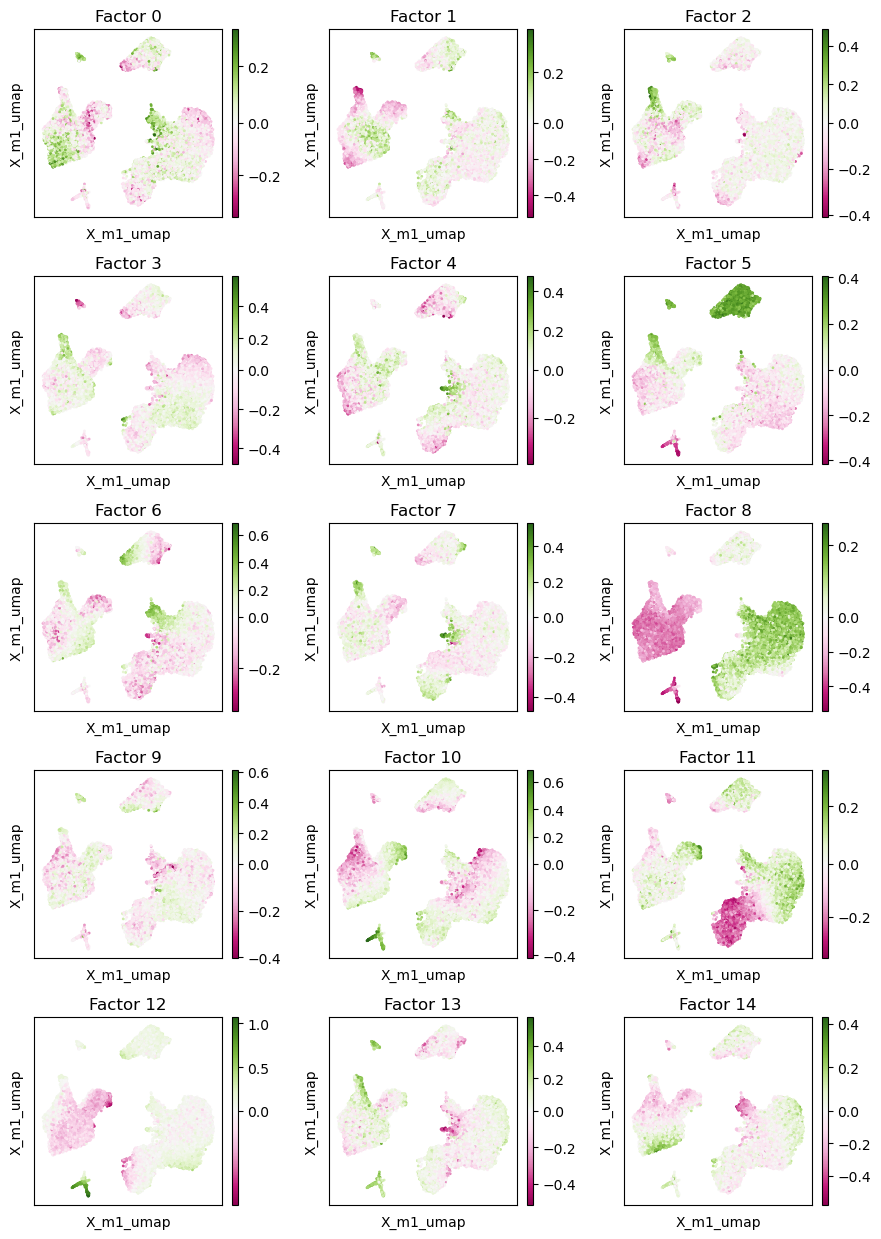

In [120]:
scc.pl.factor_embedding(adata, 'm1', 'X_m1_umap', width=3, height=2.5, ncols=3)
plt.tight_layout()

### Accounting for spectral shifts across conditions using loading design matrices

Note that mixing of cells across conditions worked for all cell types except CD14+ monocytes which still clearly separate by condition. We next consider a model that specifies the design matrices $D_2$ and $B_2$.

In [126]:
Image(url="img/full_kang.png", width=150, height=100)

Note that although both matrices have a column rank of two, $B_2$ exhibits a different structure from $D_2$. Particularly, $D_2$ contains a "intercept" column full of ones and an additional column in which cells from the control and stimulated conditions are marked with zeros and ones, respectively. This design matrix instructs the model to fit a set of basis vectors to the control condition and a separate set basis vectors to the stimulated condition. Importantly, the "intercept" column of $D_2$ introduces dependency between both bases, i.e. the basis for the stimulated cells is expressed in terms of the basis vectors of the control.

In [127]:
m2 = scc.scPCA(adata, 15, layers_key='counts', design_formula='label', batch_formula='label-1')

In [128]:
m2.fit()

Epoch: 4990 | lr: 1.00E-02 | ELBO: 7821810 | Δ_10: -102260.50 | Best: 7621460: 100%|███████████████████| 5000/5000 [03:15<00:00, 25.60it/s]


In [129]:
m2.fit(lr=0.001, num_epochs=2000)

Epoch: 6990 | lr: 1.00E-03 | ELBO: 7834728 | Δ_10: -13340.00 | Best: 7567539: 100%|████████████████████| 2000/2000 [01:18<00:00, 25.57it/s]


In [130]:
m2.mean_to_anndata(model_key='m2')

Predicting z for obs 24576-24672.: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.05it/s]


Visual inspection of the UMAP suggests finally good mixing of the full dataset including CD14+ monocytes.

In [131]:
scc.tl.umap(adata, 'X_m2')

/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/voehring/gpu-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


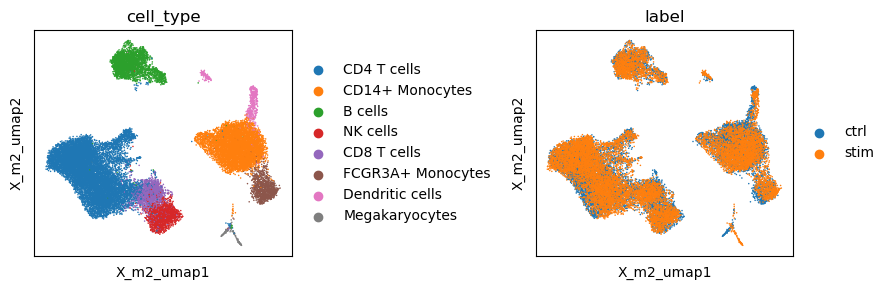

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
sc.pl.embedding(adata, basis='X_m2_umap', color='cell_type', show=False, ax=ax[0])
sc.pl.embedding(adata, basis='X_m2_umap', color='label', show=False, ax=ax[1])
plt.tight_layout()

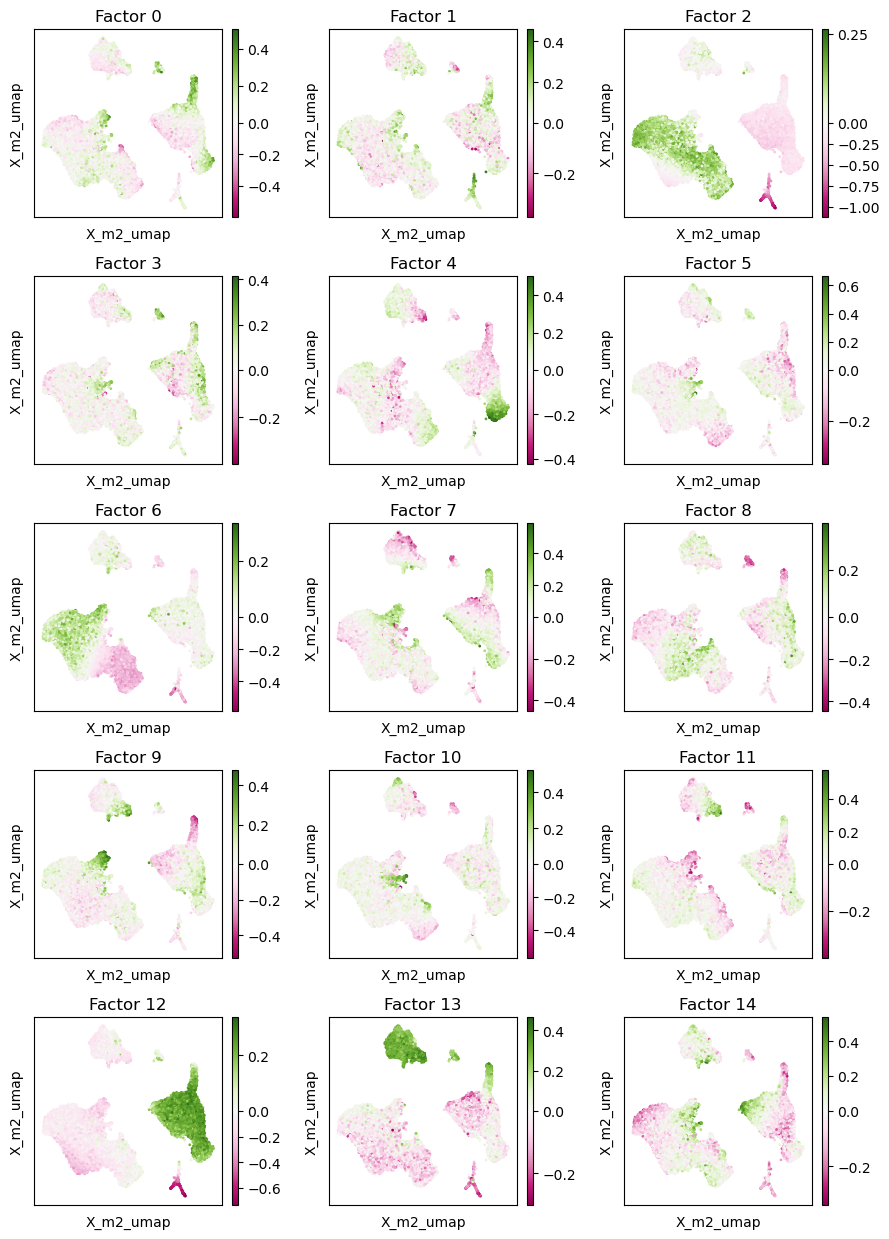

In [134]:
scc.pl.factor_embedding(adata, 'm2', 'X_m2_umap', width=3, height=2.5, ncols=3)
plt.tight_layout()